# Setup

In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

COCO_PATH = '../../data/coco/'
COCO_ANNO_PATH = COCO_PATH + 'annotations/'

# load the data from captions
import json
from six.moves import cPickle as pkl

import re
import sys
import os

CWD = os.getcwd()
COCO_TEXT_PATH = CWD+'/../../coco-text/'
sys.path.insert(0, COCO_TEXT_PATH)
import coco_text as ct


In [2]:
"""
Frequency Analysis
"""
with open(COCO_ANNO_PATH + 'captions_train2014.json') as f:
    coco_captions = json.load(f)
    
    # build the reverse dictionary, from img_id to captions, img_infos, and annotations
    img_captions = {}
    for img_info in coco_captions['images']:
        mid = str(img_info['id'])
        if not mid in img_captions:
            img_captions[mid] = {}
        img_captions[mid]['image'] = img_info
        
    for cap_info in coco_captions['annotations']:
        mid = str(cap_info['image_id'])
        if not 'annotation' in img_captions[mid]:
            img_captions[mid]['annotation'] = []
            img_captions[mid]['captions'] = ''
        img_captions[mid]['annotation'].append(cap_info)
        img_captions[mid]['captions'] += str(cap_info['caption']) + ' '
        

In [3]:
"""
Import Coco Text
"""
ct = ct.COCO_Text(COCO_PATH + 'COCO_Text.json')

loading annotations into memory...
0:00:03.017248
creating index...
index created!


In [4]:
"""extract coco-text annotations and pack into img-captions"""
# print ct.getImgIds(imgIds=ct.train, catIds=[('legibility','legible')])
# print ct.getAnnIds(imgIds=[294914])
# print img_captions["294914"]
for imgId in img_captions.keys():
    annIds = ct.getAnnIds(imgIds=[int(imgId)])
    anns = ct.loadAnns(ids = annIds)
    img_captions[imgId]["texts"] = anns

print img_captions["294914"]

{'captions': 'A suitcase that is next to a bag. A piece of luggage covered in luggage tags The luggage contains tags from several different locations. A piece of luggage that has paper tags on it. A suitcase is waiting to be claimed in an airport. ', 'image': {u'license': 3, u'file_name': u'COCO_train2014_000000294914.jpg', u'coco_url': u'http://mscoco.org/images/294914', u'height': 425, u'width': 640, u'date_captured': u'2013-11-18 11:18:21', u'flickr_url': u'http://farm4.staticflickr.com/3032/2538554933_c1bef44aab_z.jpg', u'id': 294914}, 'annotation': [{u'image_id': 294914, u'id': 749830, u'caption': u'A suitcase that is next to a bag.'}, {u'image_id': 294914, u'id': 752091, u'caption': u'A piece of luggage covered in luggage tags'}, {u'image_id': 294914, u'id': 754334, u'caption': u'The luggage contains tags from several different locations.'}, {u'image_id': 294914, u'id': 754460, u'caption': u'A piece of luggage that has paper tags on it.'}, {u'image_id': 294914, u'id': 755048, u'c

In [5]:
def filter_img_id(f):
    """Compute img-ids with a filter function f that takes in an annotation and returns a boolean."""
    output = []
    for imgId in img_captions.keys():
        tmp = filter(f, img_captions[imgId]["texts"])
        if len(tmp)>0:
            output.append(imgId)
    return output

def _is_large(ann, threshold = 0.1):
    img_id = ann['image_id']
    img_info = img_captions[str(img_id)]['image']
    h,w = img_info['height'], img_info['width']
    return ann['area']>=h*w*threshold

results = [int(x) for x in filter_img_id(_is_large)]
print len(results)

with open('../../input/large_text_img_ids.pkl', 'w+') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

683


In [6]:
import re

def cal_coexist_rate(img_id, debug=False):
    cap = img_captions[img_id]['captions'].upper()
    if debug: 
        print 'Captions is :\n%s\n'%cap

    cap_words = set(re.split('([,.])*\s', cap))
    if debug:
        print '%s\n'%cap_words

    texts = ct.loadAnns(ct.getAnnIds(imgIds=int(img_id)))
    text_words = set()
    coexist_count = 0
    for text in texts:
        if not 'utf8_string' in text:
            continue
        words = text['utf8_string'].upper().split(' ')
        for word in words:
            if word in text_words:
                continue
            else:
                text_words.add(word)

            if word in cap_words:
                if debug:
                    print 'Word "%s" in caption.'%word
                coexist_count = coexist_count + 1

    print text_words
    print coexist_count/float(len(set(text_words)))
    return coexist_count/float(len(set(text_words))) 

# cal_coexist_rate('8006')
cal_coexist_rate('296614')

set([u'GV'])
0.0


0.0

# Calculating conditional coexistence rate 

In [5]:
"""helper filtering functions"""
def exclude_small_text(anns, img_id, threshold=0.1):
    """filter out the text annotations with a bounding box smaller than [threshold]*img_area"""
    img_info = img_captions[img_id]['image']
    h,w = img_info['height'], img_info['width']
    return filter(lambda ann: ann['area']>=h*w*threshold, anns)

def exclude_corner_text(anns, img_id, threshold=0.1):
    """filter out the text annotations on sides and corners"""
    img_info = img_captions[img_id]['image']
    h,w = img_info['height'], img_info['width']
    def _judge(ann):
        [x,y,bw,bh]=ann['bbox']
        return  x>=threshold*w and \
                x+bw<=(1-threshold)*w and \
                y+bh<=(1-threshold)*h and \
                y>=threshold*h
    return filter(_judge, anns)

In [6]:
"""This function calculates coexistence rate in the following manner:
For an image I, get a bag of words (no duplicate) S that appear in it, get the count
of words k that appear in I's caption. 
Return k/|S|"""

def calculate_population_coexist_stat(flags={}):
    """flag: 
    [] -- all captions
    size: n -- excluding small bboxes with size less than n
    corner: d -- excluding all texts entirely within d pixels to the sides"""
    coexists = []

    for img_id in img_captions.keys():
        cap = img_captions[img_id]['captions'].upper()
        cap_words = set(re.split('([,.])*\s', cap))

        texts = ct.loadAnns(ct.getAnnIds(imgIds=int(img_id)))
        
        #filtering
        if 'size' in flags:
            texts = exclude_small_text(texts, img_id , threshold=flags['size'])
        if 'corner' in flags:
            texts = exclude_corner_text(texts, img_id, threshold=flags['corner'])
        
        if len(texts) == 0:
            continue

        text_words = set()
        coexist_count = 0
        for text in texts:
            if not 'utf8_string' in text:
                continue
            words = text['utf8_string'].upper().split(' ')
            for word in words:
                if word in text_words:
                    continue
                else:
                    text_words.add(word)

                if word in cap_words:
                    coexist_count = coexist_count + 1      
                    
        if len(text_words) == 0:
            continue

        img_captions[img_id]['coexistence_data'] = {
            'count'      : coexist_count,
            'text_count' : len(text_words),
            'rate'       : coexist_count/float(len(text_words))
        }

        coexists.append((coexist_count, len(text_words),coexist_count/float(len(text_words)), img_id))
    return coexists

coexists_large = calculate_population_coexist_stat({'size':0.05})
coexists_center = calculate_population_coexist_stat({'corner':0.25})
coexists_all = calculate_population_coexist_stat()

In [9]:
ids = [id for _, _, rate, id in coexists_all if rate >= 0.9]
print len(ids)

with open('../../input/high_coexist_img_ids.pkl', 'w+') as f:
    pkl.dump(ids, f, protocol=pkl.HIGHEST_PROTOCOL)

1013


In [7]:

import statistics

def get_stat(data):
    if len(data)==0: return;
    print ""
    print "Total:\t%d;\t\tMean:\t\t%f;\tNonezero:\t%d"%(len(data), statistics.mean(data), len(filter(lambda x:x!=0, data)))
    print "Median:\t%f;\tMedian(H):\t%f;\tMedian(L):\t%f;"%(statistics.median(data), statistics.median_high(data), statistics.median_low(data))
    print "Max:\t%f;\tMin:\t\t%f;\tStd:\t\t%f"%(max(data), min(data),statistics.stdev(data))
    print "\n"

dataset = coexists_center
print "Dataset has size:%d" % len(dataset)
# for i in [0,1,2]:
print "Coexistence rate summary for images with larger texts."
get_stat(map(lambda x:x[2], dataset))


Dataset has size:10594
Coexistence rate summary for images with larger texts.

Total:	10594;		Mean:		0.135520;	Nonezero:	2567
Median:	0.000000;	Median(H):	0.000000;	Median(L):	0.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.291835




In [13]:
"""This cell calculates category-specific coexistence rate in a slightly different manner than above.
Since we are focusing no a single annotation's attribute, we calculate coexistence rate for each annotation
as (# of words in annotation that appears in caption)/(# of words in annotations, no duplicates).
We calculate the mean for each category afterwords."""

def cal_ann_coexist_rate(ann):
    if not "utf8_string"  in ann:
        return None
    caption = img_captions[str(ann['image_id'])]['captions']
    text = ann['utf8_string']
    count = 0 
    seen = set()
    for word in text:
        if word in seen:
            continue
        if word in caption:
            count+=1
        seen.add(word)
    return 1.0*count/len(seen)
    

"""
Calculate conditional coexistence mean for category.
“class”                  :   str     # ‘machine printed’ or ‘handwritten’ or ‘others’
“legibility”             :   str     # ‘legible’ or ‘illegible’
“language”               :   str     # ‘english’ or ‘not english’ or ‘na’
"""
def calc_cond_coexist_mean():
    class_score = {"machine printed":[], "handwritten":[], "others":[]}
    legib_score = {"legible":[], "illegible":[]}
    lang_score = {"english":[], "not english":[], "na":[]}
    for img_id in img_captions.keys():
        cap = img_captions[img_id]['captions'].upper()
        cap_words = set(re.split('([,.])*\s', cap))

        anns = ct.loadAnns(ct.getAnnIds(imgIds=int(img_id)))
        
        #disregard any no-text images
        if len(anns)==0:
            continue
            
        #calculate coexistence rate for this image
        for ann in anns:
            rate = cal_ann_coexist_rate(ann)
            #essentially disregard all illegible texts, which kinda betrays the point 
            if rate is None: 
                continue
            class_score[ann['class']].append(rate)
            legib_score[ann['legibility']].append(rate)
            lang_score[ann['language']].append(rate)
    return class_score, legib_score, lang_score

#get statistics
clas, legib, lang = calc_cond_coexist_mean()

In [45]:
# save to pickle
with open('../../stats/class_cond.pkl','wb') as f:
    pkl.dump(clas, f, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(legib, f, protocol=pkl.HIGHEST_PROTOCOL)
    pkl.dump(lang, f, protocol=pkl.HIGHEST_PROTOCOL)


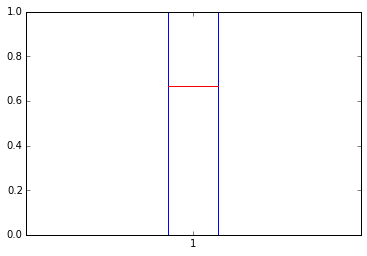

In [47]:
plt.boxplot(clas['machine printed'])
plt.show()

In [20]:
#print statistics
def print_cond_stat(flags='CLA'):
    """
    'C' for printing class, 'L' for printing legibility, 'A' for printing language
    """
    def _incr(l=[-1]): l[0]+=1; return l[0];
    figs = []
    if 'C' in flags:
        print("Conditioned on [class]")
        print("Machine printed:")
        get_stat(clas["machine printed"])
        f = plt.figure(_incr())
        plt.hist(clas["machine printed"], 20, normed= 0,  facecolor='r', alpha=0.5)
        plt.title("machine printed")
        figs.append(f)
        print("Handwritten:")
        get_stat(clas["handwritten"])
        f = plt.figure(_incr())
        plt.hist(clas["handwritten"], 20, normed= 0,  facecolor='r', alpha=0.5)
        plt.title("handwritten")
        figs.append(f)
        print("Others:")
        get_stat(clas["others"])
        f = plt.figure(_incr())
        plt.hist(clas["others"], 20, normed= 0,  facecolor='r', alpha=0.5)
        plt.title("others")
        figs.append(f)
    if 'L' in flags:
        print("Conditioned on [legibility]")
        print("Legible:")
        get_stat(legib["legible"])
        f = plt.figure(_incr())
        plt.hist(legib["legible"], 20, normed= 0,  facecolor='r', alpha=0.5)
        plt.title("legible")
        figs.append(f)
#         print("Illegible:")
#         get_stat(legib["illegible"])
#         plt.figure(_incr())
#         plt.hist(legib["illegible"], 20, normed= 0,  facecolor='r', alpha=0.5)
    if 'A' in flags:
        print("Conditioned on [language]")
        print("English")
        get_stat(lang["english"])
        f = plt.figure(_incr())
        plt.hist(lang["english"], 20, normed= 0,  facecolor='r', alpha=0.5)
        plt.title("english")
        figs.append(f)
#         print("Not english")
#         get_stat(lang["not english"])
#         plt.figure(_incr())
#         plt.hist(lang["not english"], 20, normed= 0,  facecolor='r', alpha=0.5)
#         plt.title("not english")
#         print("NA")
#         get_stat(lang["na"])
#         plt.figure(_incr())
#         plt.hist(lang["na"], 20, normed= 0,  facecolor='r', alpha=0.5)
#         plt.title("na")
    return figs

print_cond_stat('C')

Conditioned on [class]
Machine printed:

Total:	94028;		Mean:		0.542290;	Nonezero:	66233
Median:	0.666667;	Median(H):	0.666667;	Median(L):	0.666667;
Max:	1.000000;	Min:		0.000000;	Std:		0.433845


Handwritten:

Total:	4829;		Mean:		0.557745;	Nonezero:	3593
Median:	0.714286;	Median(H):	0.714286;	Median(L):	0.714286;
Max:	1.000000;	Min:		0.000000;	Std:		0.417883


Others:

Total:	1990;		Mean:		0.514228;	Nonezero:	1303
Median:	0.500000;	Median(H):	0.500000;	Median(L):	0.500000;
Max:	1.000000;	Min:		0.000000;	Std:		0.439774




# Plots

In [10]:
"""
Demo of the histogram (hist) function with a few features.

In addition to the basic histogram, this demo shows a few optional features:

    * Setting the number of data bins
    * The ``normed`` flag, which normalizes bin heights so that the integral of
      the histogram is 1. The resulting histogram is a probability density.
    * Setting the face color of the bars
    * Setting the opacity (alpha value).

"""
def count(data, num_bins):
    out=[]
    step =1./num_bins
    total = float(len(data))
    for i in range(num_bins):
        if i==num_bins-1:
            out.append(len(filter(lambda x: i*step<=x[2],data))/total)
            break
        out.append(len(filter(lambda x: i*step<=x[2]<(i+1)*step ,data))/total)
    return out

def plot(data,color, num_bins=20):
    print "Dataset has size %d"%len(data)
    # the histogram of the data
#     n, bins, patches = plt.hist(map(lambda x:x[2], data), num_bins, normed= 1,  facecolor=color, alpha=0.5)
    plt.plot(np.arange(0,1,1./num_bins),count(data, num_bins), color+'-', linewidth=2)
    
    # add a 'best fit' line
    plt.xlabel('Coexistence Rate')
    plt.ylabel('Frequency')
    plt.title('Coexistence Rate Distribution')

    # Tweak spacing to prevent clipping of ylabel
    plt.subplots_adjust(left=0.15)

plot(coexists_all, 'r')
plot(coexists_large, 'g')
plot(coexists_center, 'b')
plt.show()

Dataset has size 21536
Dataset has size 925
Dataset has size 10594


### Below is the different normalized distribution of coexistence rate of all images with texts vs. images with large text (area threshol=5%).

In [8]:
plt.figure()
plt.hist(map(lambda x:x[2], coexists_all), 20,normed= 0,  facecolor='green', alpha=0.5)
plt.title('All images')
plt.ylabel('Frequency')

plt.figure()
plt.hist(map(lambda x:x[2], coexists_large), 20, normed= 0,  facecolor='green', alpha=0.5)
plt.xlabel('Images with large text')
plt.ylabel('Frequency')

plt.figure()
plt.hist(map(lambda x:x[2], coexists_center), 20, normed= 0,  facecolor='green', alpha=0.5)
plt.xlabel('Images with center text')
plt.ylabel('Frequency')

plt.show()


In [9]:

"""
Filter out the max most bunch
"""
# len(img_captions)

high_rates_images = [img_captions[k] for k in img_captions.keys() if ('coexistence_data' in img_captions[k] and img_captions[k]['coexistence_data']['rate'] > 0.9)]
print len(high_rates_images)


1012


In [65]:
print coexists_center[0]
img_captions['376385']['annotation']

(0, 1, 0.0, '376385')


[{u'caption': u'A large crowd is watching a baseball game.',
  u'id': 587066,
  u'image_id': 376385},
 {u'caption': u'Home plate at a professional baseball game, as everyone gets ready.',
  u'id': 588155,
  u'image_id': 376385},
 {u'caption': u'A group of baseball players standing on top of a green field.',
  u'id': 588377,
  u'image_id': 376385},
 {u'caption': u'the ump calling a strike the catcher throwing the ball back to the pitcher and the batter has a strike',
  u'id': 591974,
  u'image_id': 376385},
 {u'caption': u'A baseball game in progress with the batter up to plate.',
  u'id': 592115,
  u'image_id': 376385}]